#Майнор ИАД. Домашнее задание 3. YOLO.

В этом задании вы напишете и обучите свой собственный YOLO детектор. Нужно будет разобраться со статьей: понять какого формата должна быть обучающая пара (x, y), как перевести лосс из математической формулы в питоновский код - ну и конечно понять и реализовать саму архитектуру модели.

Выборка на котрой мы будем обучать модель состоит из разнообразных фотографий яблок, бананов и апельсинов. Данные скачиваем [отсюда](https://drive.google.com/file/d/1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3/view?usp=sharing).

Баллы за ДЗ распределены следующим образом:
- Выборка для YoloV1 - 2 балла
- YOLO модель - 2 балла
- YOLO Loss - 3 балла
- Вспомогательные функции - 2 балла
- Обучение и расчет метрик - 2 балла

Для построения и обучения можно использовать как pytorch, так и pytorch-lightning.

Да-да, баллов в сумме получается 11

In [ ]:
# Данная библиотека понадобится нам, чтобы обработать разметку
! pip install xmltodict pytorch-lightning -q

Скачаем данные

In [ ]:
!wget --quiet --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://drive.google.com/uc?export=download&id=1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3" -O data.zip && rm -rf /tmp/cookies.txt
!unzip -q data.zip
!rm data.zip
!ls -l

Посмотрим как выглядит один из файлов разметки

In [ ]:
!cat data/train/apple_3.xml

## Релизуйте выборку для YoloV1 - 2 балла

In [ ]:
import os
import cv2
import json
import glob
import tqdm
import xmltodict

from IPython.core.display import struct

from typing import List

import pandas as pd
import numpy as np

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl

import albumentations as A
import albumentations.pytorch

from PIL import Image

import matplotlib.pyplot as plt

from sklearn.metrics import auc
# Добавьте необходимые вам библиотеки, если их не окажется в списке выше

Так как в этом домашнем задании использовать аугментации для обучения __обязательно__ - советуем воспользоваться библиотекой albumentations.

Она  особенно удобна, поскольку умеет сама вычислять новые координаты bounding box'ов после трансформаций картинки. Для знакомства с этим механизмом советуем следующий [гайд](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/).

Вы все еще можете избрать путь torchvision.transforms, вам потребуется знакомый нам метод `__getitem__`, однако вычислять новые координаты bounding box'ов после трансформаций вам придётся вручную

__Обратите внимание__ на то, что в статье коробки предсказаний параметризуются через: _(x_center, y_center, width, height)_ (причем эти значения _относительные_), а в наших файлах - это _(x_min, y_min, x_max, y_max)_

Также, помните что модель должна предсказывать как прямоугольник с обьектом, так и вероятности каждого класса!

In [ ]:
class2tag = {"apple": 0, "orange": 1, "banana": 2}

class FruitDataset(Dataset):
    def __init__(self, data_dir, transforms=None, S=7, B=2, C=3):
        self.image_paths = sorted(glob.glob(os.path.join(data_dir, "*.jpg")))
        self.box_paths = sorted(glob.glob(os.path.join(data_dir, "*.xml")))

        assert len(self.image_paths) == len(self.box_paths)

        self.transforms = transforms
        self.S = S
        self.B = B
        self.C = C

    def __getitem__(self, idx):
        image = np.array(Image.open(self.image_paths[idx]).convert("RGB"))
        boxes, class_labels = self.__get_boxes_from_xml(self.box_paths[idx])

        im_w = image.shape[1]
        im_h = image.shape[0]
        boxes = [self.__convert_to_yolo_box_params(box, im_w, im_h) for box in boxes]

        if self.transforms:
          image, boxes, class_labels = self.transforms(
              image=image,
              bboxes=boxes,
              class_labels=class_labels
          ).values()

        boxes = np.asarray(boxes)
        class_labels = np.asarray(class_labels)
        target = np.concatenate(
            (class_labels, boxes),
            axis=1
        ).tolist()

        image = torch.tensor(image, dtype=torch.float)
        image = image.permute(2, 0, 1)

        target_tensor = torch.zeros((self.S, self.S, 5 * self.B + self.C))

        for box in target:
          class_label, x, y, w, h = box
          class_label = int(class_label)

          row, column = int(self.S * y), int(self.S * x)

          # объект присутствует в ячейке
          target_tensor[row, column, self.C] = 1

          # устанавливаем координаты объекта
          box_coordinates = torch.tensor([x, y, w, h])
          target_tensor[row, column, self.C + 1 : (self.C + 1) + 4] = box_coordinates

          # устанавливем класс объекта
          target_tensor[row, column, class_label] = 1

        return image, target_tensor

    def __len__(self):
        return len(self.image_paths)

    def __get_boxes_from_xml(self, xml_filename: str):
        """
        Метод, который считает и распарсит (с помощью xmltodict) переданный xml
        файл и вернет координаты прямоугольников обьектов на соответсвующей фотографии
        и название класса обьекта в каждом прямоугольнике

        Обратите внимание, что обьектов может быть как несколько, так и один единственный
        """
        boxes = []
        class_labels = []

        xml_file = open(xml_filename, 'r').read()
        xml_dict = xmltodict.parse(xml_file)
        objects = xml_dict['annotation']['object']

        if type(objects) == dict:
          boxes.append(
              list(
                  map(
                      int,
                      objects['bndbox'].values()
                  )
              )
          )
          class_labels.append(
              [
                  class2tag[objects['name']]
               ]
          )

        else:
          for fruit in range(len(objects)):
            boxes.append(
                list(
                    map(
                        int,
                        objects[fruit]['bndbox'].values()
                    )
                )
            )
            class_labels.append(
                [
                    class2tag[objects[fruit]['name']]
                ]
            )

        return boxes, class_labels

    def __convert_to_yolo_box_params(self, box_coordinates: List[int], im_w, im_h):
        """
        Перейти от [xmin, ymin, xmax, ymax] к [x_center, y_center, width, height].

        Обратите внимание, что параметры [x_center, y_center, width, height] - это
        относительные значение в отрезке [0, 1]

        :param: box_coordinates - координаты коробки в формате [xmin, ymin, xmax, ymax]
        :param: im_w - ширина исходного изображения
        :param: im_h - высота исходного изображения

        :return: координаты коробки в формате [x_center, y_center, width, height]
        """
        ans = []

        ans.append((box_coordinates[0] + box_coordinates[2]) / 2 / im_w)  # x_center
        ans.append((box_coordinates[1] + box_coordinates[3]) / 2 / im_h)  # y_center

        ans.append((box_coordinates[2] - box_coordinates[0]) / im_w)  # width
        ans.append((box_coordinates[3] - box_coordinates[1]) / im_h)  # height

        return ans

In [ ]:
WIDTH, HEIGHT = 448, 448

train_transform = A.Compose([
    A.Resize(height=HEIGHT, width=WIDTH),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2)],
    bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

test_transform = A.Compose([
    A.Resize(height=HEIGHT, width=WIDTH),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2)],
    bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

In [ ]:
train_dataset = FruitDataset(
    transforms=train_transform,
    data_dir="./data/train"
    )

val_dataset = FruitDataset(
    transforms=test_transform,
    data_dir="./data/test"
    )

In [ ]:
# Немного проверок, чтобы убедиться в правильности направления решения
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[0][0], torch.Tensor)
print("Тесты успешно пройдены")

In [ ]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=4,
    shuffle=True)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=4,
    shuffle=False
    )

Теперь определим функцию для рассчета Intersection Over Union по 4 углам двух прямоугольников

In [ ]:
def IoU(predicted_bbox: torch.tensor, gt_bbox: torch.tensor) -> torch.tensor:
    """
    Intersection Over Union для двух прямоугольников

    :param: predicted_bbox - torch.tensor с коробками в формате [x_center, y_center, width, height]
    :param: gt_bbox - torch.tensor с коробками в формате [x_center, y_center, width, height]

    :return: Intersection Over Union - torch.tensor
    """

    #
    #            <-----> x_center
    #       (0, 0)---------------------(1, 0)
    #          /\|                     |
    #          |||   _____             |               x_center - (weight / 2) = x_min
    # y_center |||  |     |            |          ==>  y_center - (height / 2) = y_min
    #          \/|  |  *  |            |          ==>  x_center + (weight / 2) = x_max
    #            |  |_____|            |               y_center + (height / 2) = y_max
    #            |                     |
    #       (0, 1)---------------------(1, 1)
    #
    #
    # 0:1 = x_center, 1:2 = y_center, 2:3 = weight, 3:4 = height

    pred_x_min = predicted_bbox[..., 0:1] - (predicted_bbox[..., 2:3] / 2)
    pred_y_min = predicted_bbox[..., 1:2] - (predicted_bbox[..., 3:4] / 2)
    pred_x_max = predicted_bbox[..., 0:1] + (predicted_bbox[..., 2:3] / 2)
    pred_y_max = predicted_bbox[..., 1:2] + (predicted_bbox[..., 3:4] / 2)

    true_x_min = gt_bbox[..., 0:1] - (gt_bbox[..., 2:3] / 2)
    true_y_min = gt_bbox[..., 1:2] - (gt_bbox[..., 3:4] / 2)
    true_x_max = gt_bbox[..., 0:1] + (gt_bbox[..., 2:3] / 2)
    true_y_max = gt_bbox[..., 1:2] + (gt_bbox[..., 3:4] / 2)

    # Вычисляем координаты пересечения
    x_min = torch.max(pred_x_min, true_x_min)
    y_min = torch.max(pred_y_min, true_y_min)
    x_max = torch.min(pred_x_max, true_x_max)
    y_max = torch.min(pred_y_max, true_y_max)

    # Если разности получатся отрицательными, заменим их на нули
    # Это значит, что прямоугольники не пересекаются
    intersection = (x_max - x_min).clamp(0) * (y_max - y_min).clamp(0)

    pred_bbox_area = abs((pred_x_max - pred_x_min) * (pred_y_max - pred_y_min))
    true_bbox_area = abs((true_x_max - true_x_min) * (true_y_max - true_y_min))

    return intersection / (pred_bbox_area + true_bbox_area - intersection + 1e-6)

Теперь начинается основная часть домашнего задания: обучите модель YOLO для object detection на __обучающем__ датасете.

 - Создайте модель и функцию ошибки YoloV1 прочитав [оригинальную статью](https://paperswithcode.com/paper/you-only-look-once-unified-real-time-object)
 - Напишите функцию обучения модели
 - Используйте аугментации

## Реализуйте Модель - 2 балла

Копировать точное количество слоев и параметры сверток необязательно. Главное - чтобы модель работала по принципу, описанному в статье и делала предсказание в представленном формате.


В качестве подсказки напомним, что выходом модели __для каждого обьекта__ должен быть тензор размера
__S * S * (B * 5 + С)__, где все параметры имеют такое же значение, как и в статье:

- S - количество ячеек на которое разбивается изображение по вертикали/горизонтали
- В - количество предсказываемых прямоугольников в каждой ячейке
- 5 - количество параметров для определения каждого прямоугольника (x_center, y_center, width, height, confidence)
- С - количество классов (apple, banana, orange)

Таким образом, мы для каждого окна размера __S x S__ предсказываем __В__ коробо и один класс

In [ ]:
class CNNBlock(pl.LightningModule):  # можно поменять на Lightning
    def __init__(self, in_channels, out_channels, kernel_size, is_max_pool:bool=False, **kwargs):

        super().__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)  # в статье еще не знали про батчнорм, но мы то из будущего ...
        self.leakyrelu = nn.LeakyReLU(0.1)

        self.is_maxpool = is_max_pool  # не после каждой свертки нужно делать maxpool
        self.maxpool = nn.MaxPool2d(2, stride=2)

    def forward(self, x):
        x = self.leakyrelu(self.batchnorm(self.conv(x)))

        if self.is_maxpool:
            x = self.maxpool(x)

        return x

class YOLO(pl.LightningModule):
    def __init__(self, S=7, B=2, C=3):
        """
        :param: S * S - количество ячеек на которые разбивается изображение
        :param: B - количество предсказанных прямоугольников в каждой ячейке
        :param: C - количество классов
        """

        super(YOLO, self).__init__()

        self.S = S
        self.B = B
        self.C = C

        self.model = nn.Sequential(
            CNNBlock(in_channels=3, out_channels=16, kernel_size=self.S, is_max_pool=True, stride=2, padding=3),
            CNNBlock(in_channels=16, out_channels=32, kernel_size=3, is_max_pool=True, padding=2),
            CNNBlock(in_channels=32, out_channels=32, kernel_size=1),
            CNNBlock(in_channels=32, out_channels=64, kernel_size=3, is_max_pool=True, padding=2),
            CNNBlock(in_channels=64, out_channels=32, kernel_size=1),
            CNNBlock(in_channels=32, out_channels=64, kernel_size=3, is_max_pool=True, padding=2),
            CNNBlock(in_channels=64, out_channels=64, kernel_size=1),
            CNNBlock(in_channels=64, out_channels=128, kernel_size=3, is_max_pool=True),
            nn.Flatten(),
            nn.Linear(4608, 1024),
            nn.LeakyReLU(0.1),
            nn.Linear(1024, self.S * self.S * (self.B * 5 + self.C))
        )

    def forward(self, x):
      if len(x.shape) == 3: x = x.unsqueeze(0)
      batch_size = x.shape[0]
      return self.model(x).reshape(batch_size, self.S, self.S, self.B * 5 + self.C)

In [ ]:
temp_model = YOLO()
expected_output_shape = temp_model.S * temp_model.S * (5 * temp_model.B + temp_model.C)

assert temp_model(train_dataset[0][0]).reshape(-1).shape[0] == expected_output_shape

## Реализуйте YoloLoss - 3 балла

In [ ]:
class YoloLoss(pl.LightningModule):
    def __init__(self, S=7, B=2, C=3):
        """
        :param: S * S - количество ячеек на которые разбивается изображение
        :param: B - количество предсказанных прямоугольников в каждой ячейке
        :param: C - количество классов
        """

        super().__init__()
        self.mse = nn.MSELoss(reduction="sum")

        self.S = S
        self.B = B
        self.C = C

        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # Вычисляем IоU для предсказанных коробок с целевой коробкой
        ious = []
        for j in range(self.B):
          iou = IoU(
              predictions[..., (self.C + 1) + j * 5 : (self.C + 1) + 4 + j * 5],
              target[..., self.C + 1 : (self.C + 1) + 4]
          ).unsqueeze(0)
          ious.append(iou)

        # Выбираем отвественную за предсказание коробочку (ту, которой
        # соответствует лучшее IoU)
        ious = torch.cat(ious, dim=0)
        arg_max, init_best = torch.max(ious, dim=0)

        # Учтём, что функция штрафует только в том случае, если объект присутсвует в ячейке
        # Присутствие объекта в ячейке:
        I_obj_i = target[..., self.C].unsqueeze(3)

        # ~~ ПЕРВЫЕ ДВА СЛАГАЕМЫХ ~~ #

        box_predictions = torch.zeros((predictions.shape[0], self.S, self.S, 4)).to(device)
        best = init_best

        # Лучше всего суть рекуррентной формулы в цикле объяснить на примере

        # ~ self.B = 2 ~
        # В этом случае всё отлично, значения тензора best имеют такие соответствия:
        # 0 --> predictions[..., 4:8]
        # 1 --> predictions[..., 9:13]
        # т.е. если ноль, то первая коробка оказалась лучше второй; если единица, то вторая лучше первой
        # Мы можем ловко написать это соотношение как:
        # best * predictions[..., 9:13] + (1 - best) * predictions[..., 4:8]

        # ~ self.B = 3 ~
        # Здесь фокус не сработает, потому что тензор init_best содержит уже 3 уникальных значения
        # Но соответствия сохраняются:
        # 0 --> predictions[..., 4:8]
        # 1 --> predictions[..., 9:13]
        # 2 --> predictions[..., 14:18]
        # best >= 2 - тензор, в котором на месте двоек единицы, все остальные - нули
        # Теперь можем умножить на predictions[..., 14:18], аналогично первому пункту, когда умножали
        # best на predictions[..., 9:13]
        # Нужно избавиться от двоек:
        # 1 - (best >= 2) - тензор, в котором на месте двоек нули, все остальные - единицы
        # (1 - (best >= 2)) * best - тензор best без двоек
        # Это новый тензор best и теперь self.B = 2
        # Для n > 3 мы бы повторили шаг для n - 1, потом для n - 2 и т.д., пока не дошли до n = 2

        # Заметим, что случай self.B = 2 рекуррентности не удовлетворяет

        for j in range(self.B):
          # Рекуррентная формула ломается для последних двух значений j
          if self.B - 1 - j == 1:
            box_predictions += best * predictions[..., (self.C + 1) + 5 : (self.C + 1) + 9] # j = self.B - 2
            box_predictions += (1 - best) * predictions[..., self.C + 1 : (self.C + 1) + 4] # j = self.B - 1
            break
          # j != self.B - 2, self.B - 1
          box_predictions += (best >= (self.B - 1 - j)).byte() * predictions[
              ..., (self.B * 5 + self.C) - 4 - j * 5 : (self.B * 5 + self.C) - j * 5
              ] # идём с конца
          best = best * (1 - (best >= (self.B - 1 - j)).byte())

        box_predictions *= I_obj_i

        box_targets = I_obj_i * target[..., self.C + 1 : (self.C + 1) + 4]

        # Возьмём корень от width и height
        # Предсказанные значения могут быть отрицательными, также учтём это
        # Возьмём корень от модуля и сохраним знаки предсказаний
        # Добавим 1е-6, чтобы при вычислении градиентов не получилось деления на ноль
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )

        loss = self.lambda_coord * box_loss

        # ~~ ТРЕТЬЕ СЛАГАЕМОЕ ~~ #

        confidence_score = torch.zeros((predictions.shape[0], self.S, self.S, 1)).to(device)
        best = init_best

        # Рекуррентность аналогичная, поменяются только срезы тензоров
        for j in range(self.B):
          if self.B - 1 - j == 1:
            confidence_score += best * predictions[..., self.C + 5 : (self.C + 1) + 5]
            confidence_score += (1 - best) * predictions[..., self.C : self.C + 1]
            break
          confidence_score += (best >= (self.B - 1 - j)).byte() * predictions[
              ..., (self.B * 5 + self.C - 4) - 1 - j * 5 : (self.B * 5 + self.C - 4) - j * 5
              ]
          best = best * (1 - (best >= (self.B - 1 - j)).byte())

        object_loss = self.mse(
            torch.flatten(I_obj_i * confidence_score),
            torch.flatten(I_obj_i * target[..., self.C : self.C + 1]),
        )

        loss += object_loss

        # ~~ ЧЕТВЁРТОЕ СЛАГАЕМОЕ ~~ #

        no_object_loss = self.mse(
            torch.flatten((1 - I_obj_i) * confidence_score),
            torch.flatten((1 - I_obj_i) * target[..., self.C : self.C + 1]),
        )

        loss += self.lambda_noobj * no_object_loss

        # ~~ ПЯТОЕ СЛАГАЕМОЕ ~~ #

        class_loss = self.mse(
            torch.flatten(I_obj_i * predictions[..., : self.C], end_dim=-2,),
            torch.flatten(I_obj_i * target[..., : self.C], end_dim=-2,),
        )

        loss += class_loss

        return loss

## Реализуйте дополнительные функции из статьи - 2 балла

In [ ]:
def convert_predictions(predictions: torch.tensor, S=7, B=2, C=3) -> list:
    """
    Функция, которая из тензора предсказаний извлекает все коробки в виде списков [pred_class, prob_obj, x, y, w, h]
    """
    # Для каждой ячейки получим тензор длины B * 5 + C
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, S * S, -1)

    boxes = []

    for batch_idx in range(batch_size):
      batch = predictions[batch_idx].tolist()
      batch_boxes = []

      for cell_boxes in batch:
        # Выбираем класс с максимальной вероятностью
        max_class_prob = max(cell_boxes[ : C])
        pred_class = cell_boxes.index(max_class_prob)

        cell_boxes = cell_boxes[C : ]
        boxes_from_cell = []

        for j in range(B):
          # Извлекаем prob_obj, x, y, w, h
          box = cell_boxes[j * 5 : j * 5 + 5]
          # Добавляем pred_class
          box.insert(0, pred_class)
          boxes_from_cell.append(box)

        batch_boxes.extend(boxes_from_cell)

      boxes.append(batch_boxes)

    return boxes

In [ ]:
def non_max_suppression(bboxes: list, iou_threshold=0.5, threshold=0.4) -> list:
    """
    Non Maximum Suppression для данных коробочек

    :param: bboxes - список из списков в виде [[pred_class, prob_obj, x1, y1, w1, h1], ...]
    :param: iou_threshold - float, порог для пересечения предсказанных коробок
    :param: threshold - float, порог для удаления предсказанных коробок

    :return: non_max_suppression - список
    """
    # Удаляем коробки с маленькой вероятностью нахождения объекта в них
    bboxes = [box for box in bboxes if box[1] > threshold]
    # Сортируем по вероятностям от большего к меньшему
    bboxes.sort(key=lambda box: box[1], reverse=True)

    nms_bboxes = []

    while bboxes:
      choosen_box = bboxes.pop(0)
      # Оставляем коробку, если она соответствует другому классу (тогда бессмысленно
      # делать nms) или её пересечение с выбранной коробкой меньше порога
      bboxes = [box for box in bboxes
                if (box[0] != choosen_box[0]) or
                 (IoU(
                      torch.tensor(box[2:]),
                      torch.tensor(choosen_box[2:])
                      ) < iou_threshold)
                ]
      nms_bboxes.append(choosen_box)

    return nms_bboxes

In [ ]:
def mean_average_precision(pred_boxes, true_boxes, iou_threshold=0.5, C=3):
    """
    Считает mAP для батча

    :param: pred_boxes - список из списков в виде [[pred_class, prob_obj, x1, y1, w1, h1], ...]
    :param: true_boxes - список из списков в виде [[class, 1, x1, y1, w1, h1], ...]
    :param: iou_threshold - float, порог для пересечения предсказанных коробок

    :return: mean_average_precision - float
    """
    AP_for_classes = []

    for c in range(C):
      preds = []
      gts = []

      batch_size = len(pred_boxes)

      # Ищем коробки, которые относятся к заданному классу
      # К коробке добавляем номер картинки
      for img in range(batch_size):
        for pred_box in pred_boxes[img]:
          if pred_box[0] == c: preds.append([img] + pred_box)

      for img in range(batch_size):
        for gt_box in true_boxes[img]:
          if gt_box[0] == c: gts.append([img] + gt_box)

      # Скипаем класс, если для него нет true box'ов, тогда бессмысленно считать AP
      total_true = len(gts)
      if total_true == 0:
        continue

      # Посчитаем распространнёность класса для картинок из батча
      # Например, если картинка 1 содержит 3 коробки данного класса,
      # картинка 2 - 2 коробки, то получим {0: 3, 1: 2}
      amount_class = {}
      # Добавляем единицу в список, если коробка относится к картинке img,
      # ключу ставим в соответствие сумму списка
      for img in range(batch_size):
        amount_class[img] = sum([1 for box in gts if (box[0] == img)])

      # {0: 3, 1: 2} --> {0: torch.tensor([0,0,0]), 1: torch.tensor([0,0])}
      for key, item in amount_class.items():
        amount_class[key] = torch.zeros((item))

      # Сортируем по вероятностям нахождения объекта от большего к меньшему
      preds.sort(key=lambda x: x[2], reverse=True)
      TP = torch.zeros((len(preds)))
      FP = torch.zeros((len(preds)))

      for pred_idx, pred in enumerate(preds):
        # Отбираем true box'ы только те, которые относятся к картинке, которой
        # принадлежит pred box
        gt_img = [box for box in gts if box[0] == pred[0]]
        num_gt_img = len(gt_img)

        best_iou = 0
        best_gt_idx = 0

        # Ищем лучшее пересечение и индекс коробки с лучшим пересечением
        for gt_idx, gt in enumerate(gt_img):
          iou = IoU(torch.tensor(pred[3:]), torch.tensor(gt[3:]))

          if iou > best_iou:
            best_iou = iou
            best_gt_idx = gt_idx

        if best_iou > iou_threshold:
          # Дополнительная проверка:
          # не было ли до этого более лучшего предсказания?
          if amount_class[pred[0]][best_gt_idx] == 0:
            TP[pred_idx] = 1
            amount_class[pred[0]][best_gt_idx] = 1
          else:
            FP[pred_idx] = 1 # если было, то FP
        else:
          FP[pred_idx] = 1 # если iou меньше порога, то FP

      cumulative_TP = torch.cumsum(TP, dim=0)
      cumulative_FP = torch.cumsum(FP, dim=0)

      precision = torch.div(cumulative_TP, (cumulative_TP + cumulative_FP))
      recall = torch.div(cumulative_TP, total_true)

      precision = torch.hstack((torch.tensor([1]), precision, torch.tensor([0])))
      recall = torch.hstack((torch.tensor([0]), recall, torch.tensor([1])))

      AP_for_classes.append(torch.trapezoid(precision, recall))

    return sum(AP_for_classes) / len(AP_for_classes)


In [ ]:
def get_bound_boxes(loader, model, device, iou_threshold=0.5, threshold=0.4, S=7, C=3):
    all_pred_boxes = []
    all_true_boxes = []

    model.eval()
    model.to(device)

    for batch_index, (x, y_true) in enumerate(loader):
      x, y_true = x.to(device), y_true.to(device)

      with torch.no_grad():
        y_pred = model(x)

      batch_size = x.shape[0]
      true_bboxes = convert_predictions(y_true, B=1)
      pred_bboxes = convert_predictions(y_pred)

      batch_pred_bboxes = []
      batch_true_bboxes = []

      for i in range(batch_size):
        nms_bboxes = non_max_suppression(pred_bboxes[i], iou_threshold=iou_threshold, threshold=threshold)
        batch_pred_bboxes.append(nms_bboxes)

        # Избавляемся от нулевых списков в true_bboxes
        true_bboxes[i] = [box for box in true_bboxes[i] if box[1] > threshold]
        batch_true_bboxes.append(true_bboxes[i])

      all_pred_boxes.append(batch_pred_bboxes)
      all_true_boxes.append(batch_true_bboxes)

    return all_pred_boxes, all_true_boxes

## Обучите модель и посчитайте метрики для задачи детекции - 2 балла

Несмотря на то, что в этом блоке ничего сильно нового для вас не ожидается и за него формально дается лишь два балла - провести обучение очень важно для понимания того, насколько правильно реализована ваша модель и лосс.

В процессе обучения будет видно все ли размерности совпадают, падает ли лосс и растут ли метрики целевой задачи, поэтому на практике этот пункт гораздо оказывается гораздо важнее.

In [ ]:
class YOLOLearner(pl.LightningModule):
    def __init__(self, S=7, B=2, C=3) -> None:
        super().__init__()

        self.model = YOLO(S=S, B=B, C=C)
        self.loss = YoloLoss(S=S, B=B, C=C)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)

    def forward(self, x) -> torch.Tensor:
        return self.model(x)

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        x, y = train_batch
        pred = self(x)
        loss = self.loss(pred, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx) -> None:
        x, y = val_batch
        pred = self(x)
        loss = self.loss(pred, y)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True)

In [ ]:
torch.cuda.empty_cache()

n_epochs = 10

yolo_learner = YOLOLearner(S=7, B=2, C=3)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
trainer = pl.Trainer(accelerator=device, max_epochs=n_epochs, auto_lr_find=True)

trainer.fit(yolo_learner, train_dataloader, val_dataloader)

## Посчитайте метрики задачи детекции на валидационной выборке

Попробуйте понять насколько хороши ваши показатели. Если числа кажутся подозрительно низкими - возможно вам стоит перепроверить ваше решение.

In [ ]:
all_pred_boxes, all_true_boxes = get_bound_boxes(val_dataloader, yolo_learner, device, iou_threshold=0.5, threshold=0.5)

In [ ]:
mAP_for_batches = []

for batch in range(len(all_pred_boxes)):
  mAP_for_batches.append(mean_average_precision(all_pred_boxes[batch], all_true_boxes[batch]))

sum(mAP_for_batches) / len(mAP_for_batches)

## Визуализируйте предсказанные bounding box'ы для любых пяти картинок из __валидационного__ датасета.

In [ ]:
image, targets = val_dataset[15]

In [ ]:
yolo_learner.eval()
preds = yolo_learner(image.to(device)).unsqueeze(0)

In [ ]:
from PIL import ImageDraw

image_true_boxes = torchvision.transforms.ToPILImage()(image)
draw = ImageDraw.Draw(image_true_boxes)

for S_i in range(7):
  for S_j in range(7):
    box = targets[S_i, S_j, 4:8].tolist()
    x_max = 448 * (box[0] + box[2])
    x_min = 448 * (box[0] - box[2])
    y_max = 448 * (box[1] + box[3])
    y_min = 448 * (box[1] - box[3])
    draw.rectangle([(x_min, y_min), (x_max, y_max)], outline='yellow')

image_true_boxes

In [ ]:
image_pred_boxes = torchvision.transforms.ToPILImage()(image)
draw = ImageDraw.Draw(image_pred_boxes)

boxes = non_max_suppression(convert_predictions(preds)[0])

for box in boxes:
  x_max = 448 * (box[0] + box[2])
  x_min = 448 * (box[0] - box[2])
  y_max = 448 * (box[1] + box[3])
  y_min = 448 * (box[1] - box[3])
  draw.rectangle([(x_min, y_min), (x_max, y_max)], outline='red')

image_pred_boxes

**Оценка: 7 / 11**

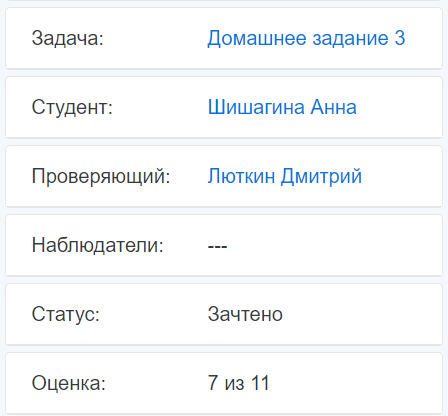